In [17]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
from time import time

import numpy as np
import scipy as sp
import pandas as pd

from scipy.optimize import fmin_powell
from scipy import integrate
from scipy import linalg

from sklearn.preprocessing import normalize
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

np.set_printoptions(precision=4, suppress=True)

from collections import Counter
from Levenshtein import distance as levenshtein_distance

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('axes', **{'titlesize': '16', 'labelsize': '16'})
rc('legend', **{'fontsize': '16'})
rc('figure', **{'dpi' : 200})

## SIR-модель распространения эпидемии

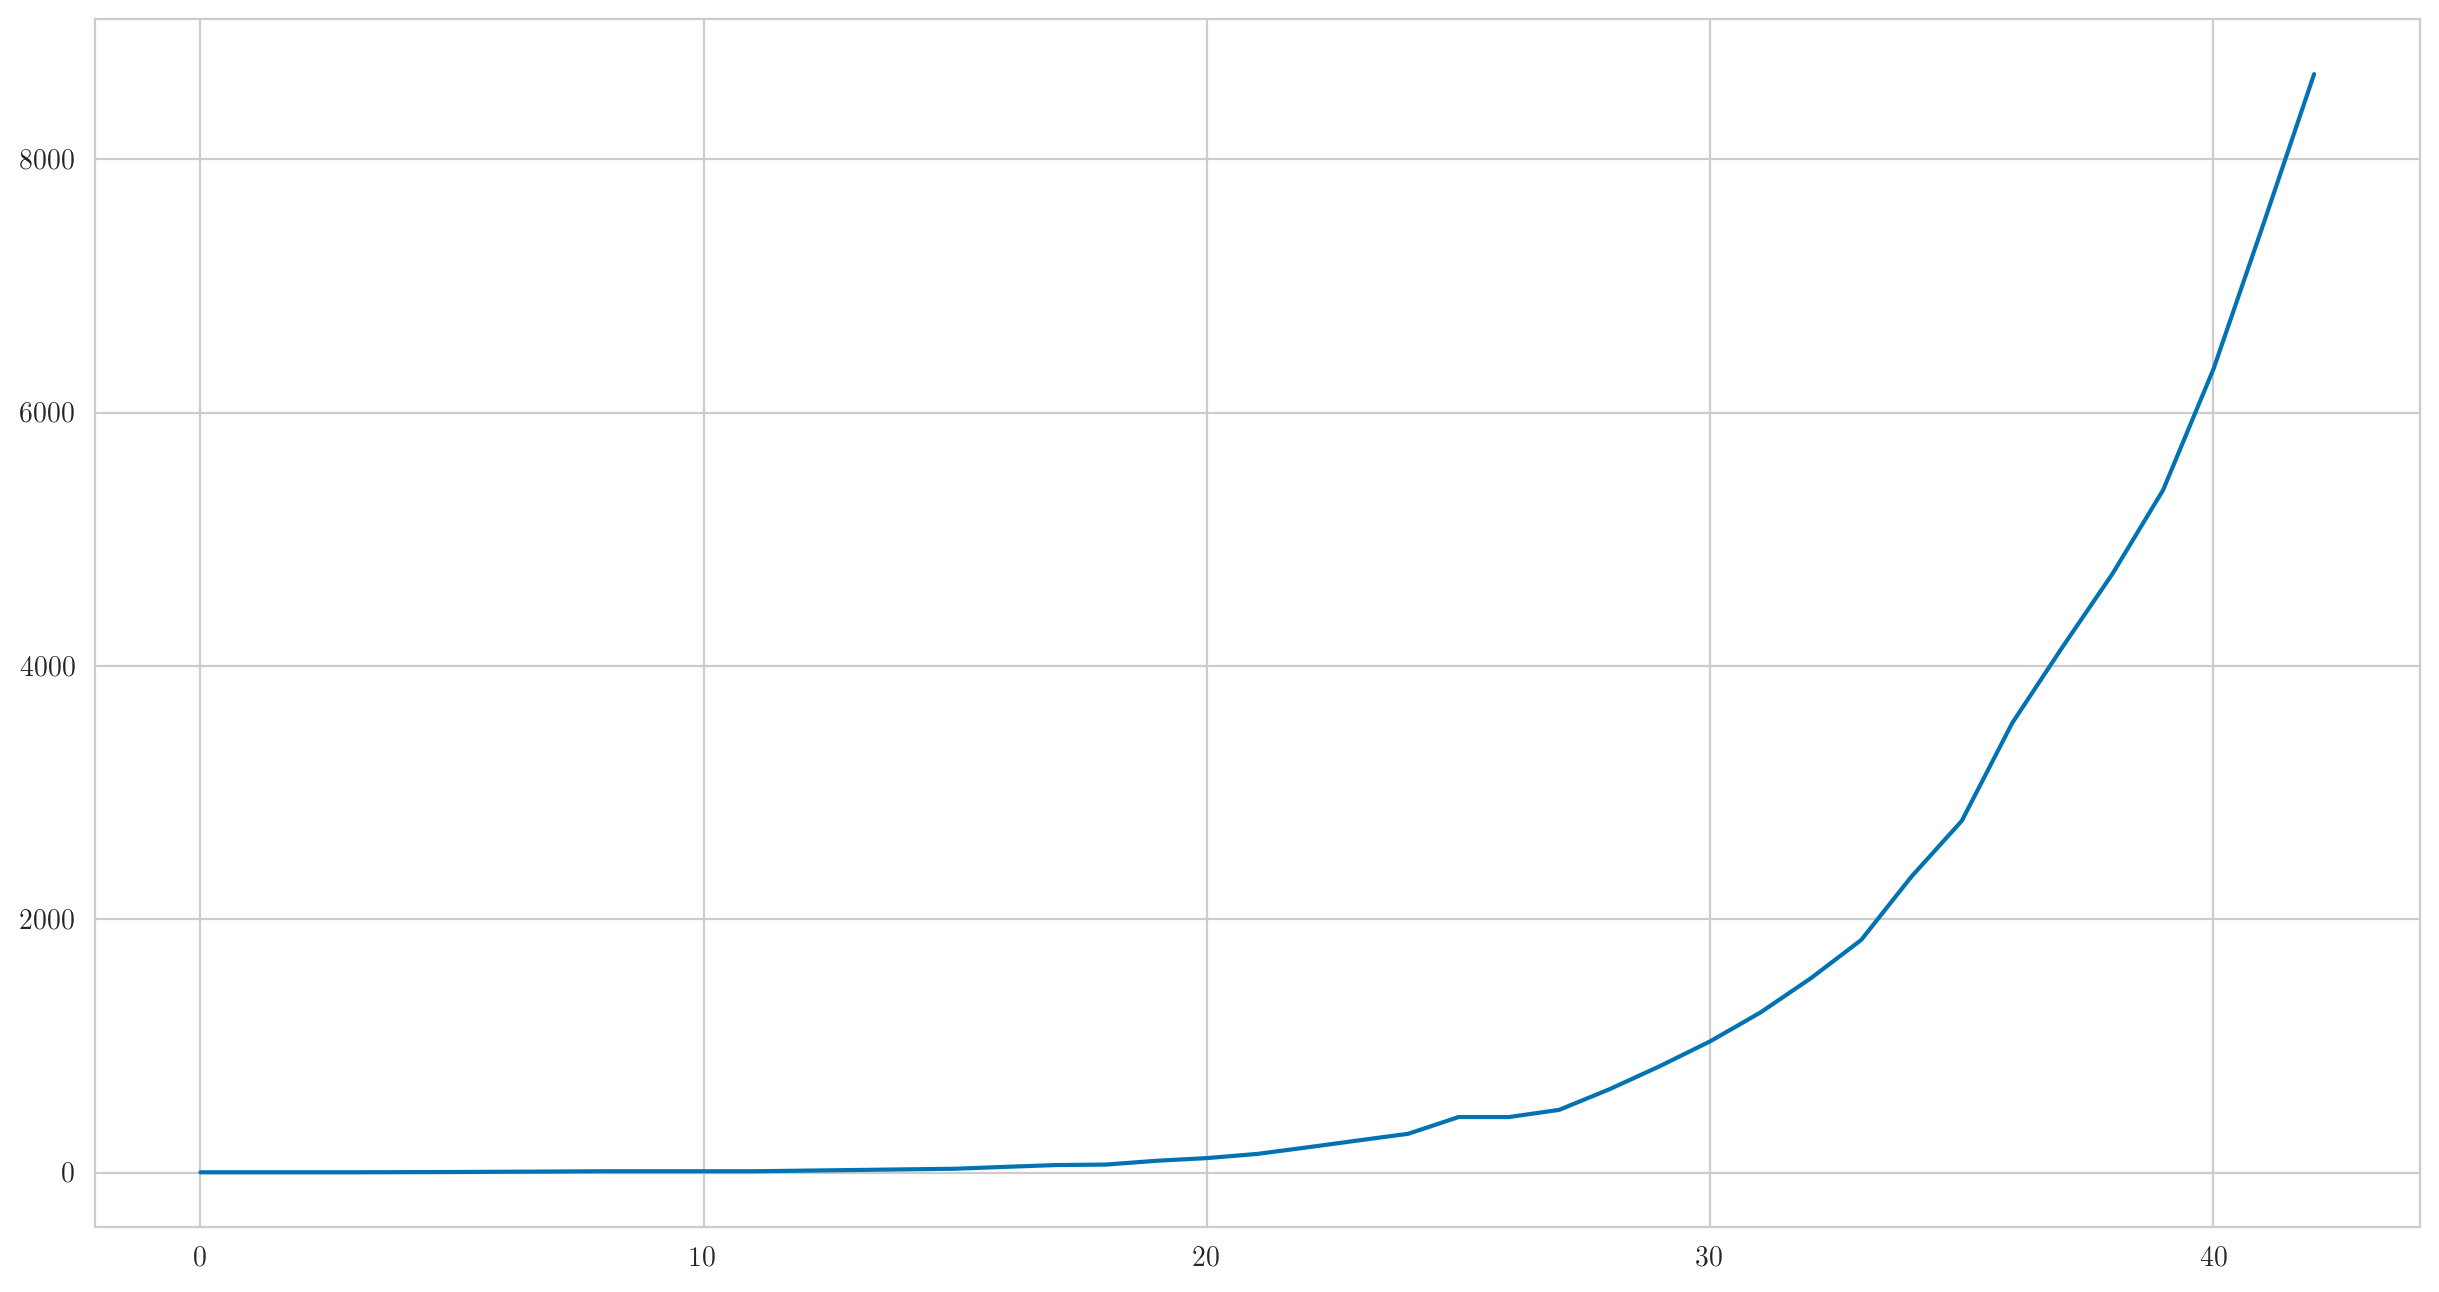

In [18]:
# Наблюдения
y = np.array([2,2,2,2,3,4,6,8,10,10,10,10,15,20,25,30,45,59,63,93,114,147,199,253,306,438,438,495,658,840,1036,1264,1534,1836,2337,2777,3548,4149,4731,5389,6343,7497,8672])
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
ax.plot(y)
T, N = len(y), 20000
init_rho, init_mu, init_beta = 0.01, 0.01, 0.00001
prior_rho_params = (1, 99)
prior_mu_params = (1, 99)
prior_beta_params = (1, 9999)

In [19]:
class SIR_MCMC:
    
    def __init__(self, prior_rho_params, prior_mu_params, prior_beta_params):
        self.param_names = ['rho', 'mu', 'beta']
        self.params = { 'rho' : prior_rho_params, 'mu' : prior_mu_params, 'beta' : prior_beta_params }
        self.params_history = { i : [x] for i,x in self.params.items() }        
        self._sample_parameters(use_means=True)

    def _sample_parameters(self, use_means=False):
        if use_means:
            self.rho, self.mu, self.beta = [ self.params[x][0] / (self.params[x][0] + self.params[x][1]) for x in self.param_names ]
        else:
            self.rho, self.mu, self.beta = [ np.random.beta(self.params[x][0], self.params[x][1]) for x in self.param_names ]
        
        self.logbeta = np.log(self.beta)
        self.logmu = np.log(self.mu)
        self.log1mbeta = np.log(1 - self.beta)
        self.log1mmu = np.log(1 - self.mu)

    def _sample_initial_trajectories(self):
        print("\t\t...rho = %.6f\tmu = %.6f\tbeta = %.6f" % (self.rho, self.mu, self.beta))
        iIter = 0
        while True:
            iIter += 1
            if iIter % 100 == 0:
                self._sample_parameters()
                print("\t\t...rho = %.6f\tmu = %.6f\tbeta = %.6f" % (self.rho, self.mu, self.beta))
            self.xs = np.zeros(shape=(self.N, 2)) - 1
            self.xs[0:self.y[0], 0] = 0
            self.arr_S, self.arr_I, self.arr_R = [self.N-self.y[0]], [self.y[0]], [0]
            
            for t in range(1, self.T):
                # переходы из S в I
                next_S_to_I = np.random.binomial(self.arr_S[-1], -np.expm1(self.arr_I[-1]*np.log(1-self.beta)) )

                # переходы из I в R
                next_I_to_R = np.random.binomial(self.arr_I[-1], self.mu)
                
                # проверяем, что вероятность такой последовательности не ноль
                if self.arr_I[-1] + next_S_to_I - next_I_to_R < self.y[t]:
                    break
                
                # обновляем траектории
                self.xs[self.arr_I[-1] + self.arr_R[-1]:self.arr_I[-1] + self.arr_R[-1] + next_S_to_I, 0] = t
                self.xs[self.arr_R[-1]:self.arr_R[-1] + next_I_to_R, 1] = t

                # обновляем массивы
                self.arr_S.append(self.arr_S[-1] - next_S_to_I)
                self.arr_I.append(self.arr_I[-1] + next_S_to_I - next_I_to_R)
                self.arr_R.append(self.arr_R[-1] + next_I_to_R)

            if len(self.arr_S) >= self.T:
                break

    def _update_state_arrays(self):
        self.arr_I = np.array([ np.sum(np.logical_and(np.logical_and(self.xs[:,0] >= 0, self.xs[:,0] <= t), np.logical_or(self.xs[:,1] < 0, self.xs[:,1] >= t))) for t in range(self.T)])
        self.arr_S = np.array([ np.sum(np.logical_or(self.xs[:,0] < 0, self.xs[:,0] > t)) for t in range(self.T)])
        self.arr_R = self.N - self.arr_I - self.arr_S
                
    def _compute_Q_matrices(self, ind_x):
        cur_x = self.xs[ind_x]
        
        ## считаем всё в логарифмах
        qs = np.zeros(shape=(self.T, 3, 3)) - np.inf
        if cur_x[0] == 0:
            qs[0,0,1] = 0.0
        else:
            qs[0,0,0] = 0.0

        if cur_x[1] == -1:
            if cur_x[0] > -1:
                arr_I_without_current = self.arr_I - np.array( np.arange(self.T) >= cur_x[0], dtype=int)
            else:
                arr_I_without_current = self.arr_I
        else:
            arr_I_without_current = self.arr_I - np.array( np.logical_and(np.arange(self.T) >= cur_x[0], np.arange(self.T) < cur_x[1]), dtype=int)
        
        for t in range(1, self.T):
            logprob_y_without_current = sp.stats.binom.logpmf(self.y[t], arr_I_without_current[t], self.rho)
            logprob_y_with_current = sp.stats.binom.logpmf(self.y[t], arr_I_without_current[t]+1, self.rho)
            qs[t] = -np.inf
            if qs[t-1, 0, 0] > -np.inf:
                logprob_stay_healthy = arr_I_without_current[t-1] * self.log1mbeta
                qs[t, 0, 0] = (qs[t-1, 0, 0]) + logprob_stay_healthy + logprob_y_without_current
                qs[t, 0, 1] = (qs[t-1, 0, 0]) + np.log(-np.expm1(logprob_stay_healthy)) + logprob_y_with_current
            prob_prev_I_state, prob_prev_R_state = np.logaddexp.reduce(qs[t-1, :, 1]), np.logaddexp.reduce(qs[t-1, :, 2])
            if prob_prev_I_state > -np.inf:
                qs[t, 1, 1] = (prob_prev_I_state) + self.log1mmu + logprob_y_with_current
                qs[t, 1, 2] = (prob_prev_I_state) + self.logmu + logprob_y_without_current
            if prob_prev_R_state > -np.inf:
                qs[t, 2, 2] = (prob_prev_R_state) + logprob_y_without_current
            qs[t] = qs[t] - np.logaddexp.reduce(qs[t], axis=(0,1))

        ## экспоненту берём только на выходе
        return np.exp(qs)
          
    def _sample_new_x(self, qs):        
#         print(qs)
        new_x = np.zeros(2)
        cur_state = np.random.choice(3, p=np.sum(qs[self.T-1], axis=1))
        new_x[cur_state:] = -1
        for t in range(T-2, -1, -1):
            new_state = np.random.choice(3, p=qs[t+1,:,cur_state] / np.sum(qs[t+1,:,cur_state]))
            if new_state < cur_state:
                new_x[new_state] = t+1
                cur_state = new_state
            if new_state == 0:
                break
        return new_x

    def _update_state_arrays(self):
        self.arr_S = np.array([ np.sum(np.logical_or(self.xs[:,0] < 0, self.xs[:,0] > t)) for t in range(self.T)])
        self.arr_R = np.array([ np.sum(np.logical_and(self.xs[:,1] >= 0, self.xs[:,1] <= t)) for t in range(self.T)])
        self.arr_I = self.N - self.arr_S - self.arr_R

    def _metropolis_hastings_loop(self, iters):
        for _ in range(iters):
            x_index = np.random.randint(self.N)
            qs = self._compute_Q_matrices(x_index)
            new_x = self._sample_new_x(qs)
            self.xs[x_index] = new_x
            self._update_state_arrays()

    ## обновляем параметры модели
    def _update_model_parameters(self):
        # сколько человек заболело и не заболело в каждый момент
        indices_infections =  np.array( self.xs[self.y[0]:,0]-1, dtype=int )
        counter_stayhealthy = Counter( [ i for x in indices_infections for i in range(0, x)] )
        counter_infections = Counter( indices_infections )
        
        # сколько ожидаемых инфицирований на каждого инфицированного
        expected_infections = np.divide( self.beta*self.arr_I, -np.expm1( self.arr_I * self.log1mbeta ) )
        expected_infections[ np.where(self.arr_I == 1) ] = 1
        expected_infections[ np.where(self.arr_I == 0) ] = 0

        # суммарные ожидаемые числа событий инфицирований и не-инфицирований
        expected_num_I_infections = np.sum([ x * expected_infections[i] for i,x in counter_infections.items()])
        expected_num_I_notinfections = np.sum([x * (self.arr_I[i] - expected_infections[i]) for i,x in counter_infections.items()])
        expected_num_S_notinfections = np.sum([ x * self.arr_I[i] for i,x in counter_stayhealthy.items() ])
                
        for x in self.param_names:
            self.params_history[x].append(self.params[x])
        current_param_updates = {
            'rho': ( np.sum(self.y), np.sum(self.arr_I) - np.sum(self.y) ),
            'mu': ( np.sum(np.diff(self.arr_R)), np.sum(self.arr_I[:-1]) - np.sum(np.diff(self.arr_R)) ),
            'beta': ( expected_num_I_infections, expected_num_I_notinfections + expected_num_S_notinfections )
        }
        for x in self.param_names:
            self.params[x] = (self.params_history[x][0][0] + current_param_updates[x][0], self.params_history[x][0][1] + current_param_updates[x][1])

            
    ### the main loop
    def fit(self, y, N, iters=3, mh_iters=500, burn_in=500, verbose=True):
        self.y, self.N, self.T = y, N, y.shape[0]
        self._sample_initial_trajectories()
        
        if verbose:
            print("Initial values:\trho = %.6f\tmu = %.6f\tbeta = %.6f" % (self.rho, self.mu, self.beta))

        self._metropolis_hastings_loop(burn_in)
            
        for iIter in range(iters):
            self._metropolis_hastings_loop(mh_iters)
            self._update_model_parameters()
            if verbose:
                print('New params: %s' % "\t".join(["%s: (%.2f,%.2f)" % (x, self.params[x][0], self.params[x][1]) for x in self.param_names]))
            self._sample_parameters(use_means=True)
            if verbose:
                print("Iteration %2d:\trho = %.6f\tmu = %.6f\tbeta = %.6f" % (iIter, self.rho, self.mu, self.beta))


In [20]:
def sample_population(N, T, true_rho, true_beta, true_mu):
    true_log1mbeta = np.log(1 - true_beta)

    cur_states = np.zeros(N)
    cur_states[:1] = 1
    cur_I, test_y, true_statistics = 1, [1], [[N-1, 1, 0]]

    for t in range(T):    
        logprob_stay_healthy = cur_I * true_log1mbeta
        for i in range(N):
            if cur_states[i] == 0 and np.random.rand() < -np.expm1(logprob_stay_healthy):
                cur_states[i] = 1
            elif cur_states[i] == 1 and np.random.rand() < true_mu:
                cur_states[i] = 2

        cur_I = np.sum(cur_states == 1)
        test_y.append( np.random.binomial( cur_I, true_rho ) )
        true_statistics.append([np.sum(cur_states == 0), np.sum(cur_states == 1), np.sum(cur_states == 2)])

    return test_y, np.array(true_statistics).T

[ 1  1  1  0  1  3  4  7 22 26 31 25 21 12 10  8  3  3  1  0  1  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
[[ 99  99  99  98  96  94  89  76  51  24   5   2   1   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   1   1   1   2   4   8  20  40  54  54  45  31  22  16  14   9   3
    2   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   2   2   3   4   9  22  41  53  68  77  84  86  91  97
   98  99  99 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
  100 100 100 100 100 100 100 100 100 100 100 100 100 100 100]]


(0.0, 50.0)

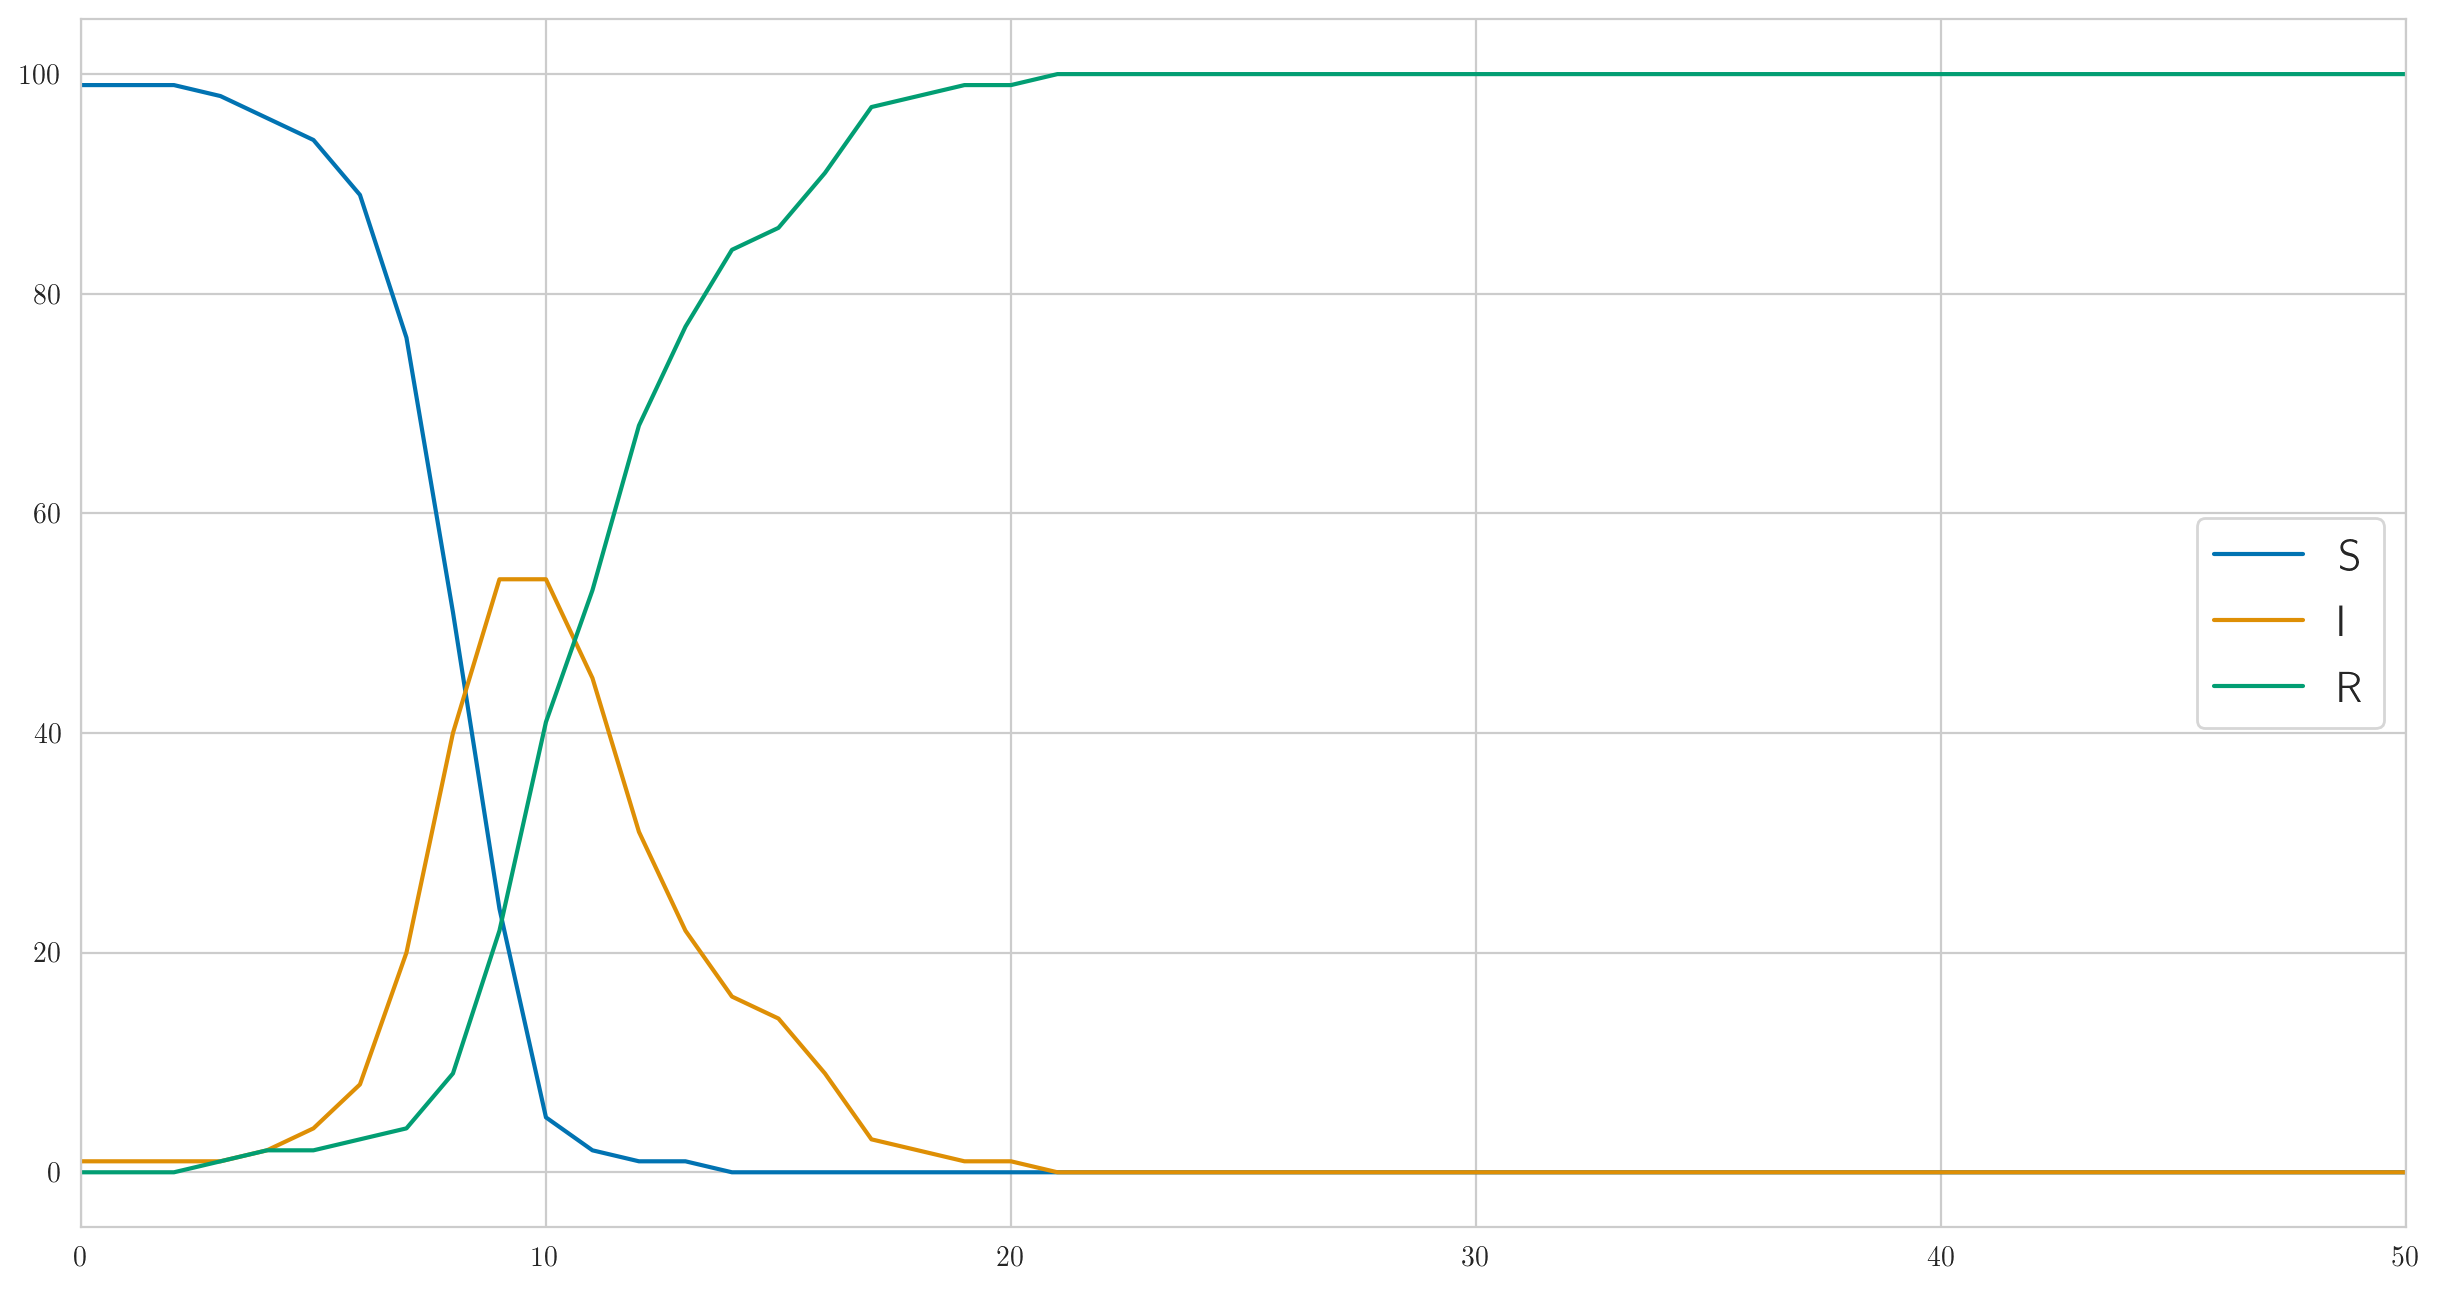

In [22]:
N, T, true_rho, true_beta, true_mu = 100, 50, 0.5, 0.02, 0.3
test_y, true_statistics = sample_population(N, T, true_rho, true_beta, true_mu)
print(np.array(test_y))
print(np.array(true_statistics))
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
ax.plot(true_statistics.T)
ax.legend(["S", "I", "R"])
ax.set_xlim((0, T))

# plt.savefig("covid-habr3.png", bbox_inches='tight')

In [23]:
print("True values: rho=%.4f\tmu=%.4f\tbeta=%.4f" % (true_rho, true_mu, true_beta))
print("Y = %s" % test_y)
model = SIR_MCMC((1, 1), (1, 1), (1, 1))
model.fit(np.array(test_y), N, iters=1500, mh_iters=int(N/10), burn_in=2*N)

True values: rho=0.5000	mu=0.3000	beta=0.0200
Y = [1, 1, 1, 0, 1, 3, 4, 7, 22, 26, 31, 25, 21, 12, 10, 8, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
		...rho = 0.500000	mu = 0.500000	beta = 0.500000
		...rho = 0.641401	mu = 0.127684	beta = 0.813737
Initial values:	rho = 0.641401	mu = 0.127684	beta = 0.813737
New params: rho: (182.00,375.00)	mu: (101.00,456.00)	beta: (1580.41,370.59)
Iteration  0:	rho = 0.326750	mu = 0.181329	beta = 0.810053
New params: rho: (182.00,465.00)	mu: (101.00,546.00)	beta: (1611.48,387.52)
Iteration  1:	rho = 0.281298	mu = 0.156105	beta = 0.806143
New params: rho: (182.00,526.00)	mu: (101.00,607.00)	beta: (1674.61,414.39)
Iteration  2:	rho = 0.257062	mu = 0.142655	beta = 0.801634
New params: rho: (182.00,564.00)	mu: (101.00,645.00)	beta: (1665.65,423.35)
Iteration  3:	rho = 0.243968	mu = 0.135389	beta = 0.797342
New params: rho: (182.00,587.00)	mu: (101.00,668.00)	beta: (1749.80,459.20)
Iteration  4

New params: rho: (182.00,1065.00)	mu: (101.00,1146.00)	beta: (1260.29,379.71)
Iteration 58:	rho = 0.145950	mu = 0.080994	beta = 0.768467
New params: rho: (182.00,1072.00)	mu: (101.00,1153.00)	beta: (1167.31,344.69)
Iteration 59:	rho = 0.145136	mu = 0.080542	beta = 0.772029
New params: rho: (182.00,1137.00)	mu: (101.00,1218.00)	beta: (1221.51,355.49)
Iteration 60:	rho = 0.137983	mu = 0.076573	beta = 0.774581
New params: rho: (182.00,1187.00)	mu: (101.00,1268.00)	beta: (1125.04,319.96)
Iteration 61:	rho = 0.132944	mu = 0.073776	beta = 0.778572
New params: rho: (182.00,1144.00)	mu: (101.00,1225.00)	beta: (1231.17,345.83)
Iteration 62:	rho = 0.137255	mu = 0.076169	beta = 0.780706
New params: rho: (182.00,1049.00)	mu: (101.00,1130.00)	beta: (1282.51,357.49)
Iteration 63:	rho = 0.147847	mu = 0.082047	beta = 0.782016
New params: rho: (182.00,1114.00)	mu: (101.00,1195.00)	beta: (1236.26,340.74)
Iteration 64:	rho = 0.140432	mu = 0.077932	beta = 0.783929
New params: rho: (182.00,1123.00)	mu: (10

New params: rho: (182.00,960.00)	mu: (101.00,1041.00)	beta: (1611.99,505.01)
Iteration 119:	rho = 0.159370	mu = 0.088441	beta = 0.761449
New params: rho: (182.00,977.00)	mu: (101.00,1058.00)	beta: (1750.56,561.44)
Iteration 120:	rho = 0.157032	mu = 0.087144	beta = 0.757164
New params: rho: (182.00,924.00)	mu: (101.00,1005.00)	beta: (1715.59,561.41)
Iteration 121:	rho = 0.164557	mu = 0.091320	beta = 0.753443
New params: rho: (182.00,938.00)	mu: (101.00,1019.00)	beta: (1732.86,579.14)
Iteration 122:	rho = 0.162500	mu = 0.090179	beta = 0.749508
New params: rho: (182.00,929.00)	mu: (101.00,1010.00)	beta: (1614.24,545.76)
Iteration 123:	rho = 0.163816	mu = 0.090909	beta = 0.747332
New params: rho: (182.00,893.00)	mu: (101.00,974.00)	beta: (1578.62,538.38)
Iteration 124:	rho = 0.169302	mu = 0.093953	beta = 0.745688
New params: rho: (182.00,901.00)	mu: (101.00,982.00)	beta: (1575.31,541.69)
Iteration 125:	rho = 0.168052	mu = 0.093259	beta = 0.744122
New params: rho: (182.00,931.00)	mu: (101.0

New params: rho: (182.00,993.00)	mu: (101.00,1074.00)	beta: (1660.38,616.62)
Iteration 179:	rho = 0.154894	mu = 0.085957	beta = 0.729197
New params: rho: (182.00,995.00)	mu: (101.00,1076.00)	beta: (1601.31,599.69)
Iteration 180:	rho = 0.154630	mu = 0.085811	beta = 0.727539
New params: rho: (182.00,1022.00)	mu: (101.00,1103.00)	beta: (1651.12,625.88)
Iteration 181:	rho = 0.151163	mu = 0.083887	beta = 0.725132
New params: rho: (182.00,1025.00)	mu: (101.00,1106.00)	beta: (1620.06,619.94)
Iteration 182:	rho = 0.150787	mu = 0.083679	beta = 0.723239
New params: rho: (182.00,980.00)	mu: (101.00,1061.00)	beta: (1530.05,586.95)
Iteration 183:	rho = 0.156627	mu = 0.086919	beta = 0.722745
New params: rho: (182.00,967.00)	mu: (101.00,1048.00)	beta: (1559.13,600.87)
Iteration 184:	rho = 0.158399	mu = 0.087903	beta = 0.721820
New params: rho: (182.00,973.00)	mu: (101.00,1054.00)	beta: (1527.19,589.81)
Iteration 185:	rho = 0.157576	mu = 0.087446	beta = 0.721393
New params: rho: (182.00,1033.00)	mu: (

New params: rho: (182.00,1115.00)	mu: (101.00,1196.00)	beta: (1631.41,944.59)
Iteration 240:	rho = 0.140324	mu = 0.077872	beta = 0.633311
New params: rho: (182.00,1117.00)	mu: (101.00,1198.00)	beta: (1616.48,948.52)
Iteration 241:	rho = 0.140108	mu = 0.077752	beta = 0.630206
New params: rho: (182.00,1115.00)	mu: (101.00,1196.00)	beta: (1572.50,928.50)
Iteration 242:	rho = 0.140324	mu = 0.077872	beta = 0.628747
New params: rho: (182.00,1130.00)	mu: (101.00,1211.00)	beta: (1556.79,923.21)
Iteration 243:	rho = 0.138720	mu = 0.076982	beta = 0.627737
New params: rho: (182.00,1117.00)	mu: (101.00,1198.00)	beta: (1510.31,894.69)
Iteration 244:	rho = 0.140108	mu = 0.077752	beta = 0.627986
New params: rho: (182.00,1085.00)	mu: (101.00,1166.00)	beta: (1541.54,915.46)
Iteration 245:	rho = 0.143646	mu = 0.079716	beta = 0.627405
New params: rho: (182.00,1066.00)	mu: (101.00,1147.00)	beta: (1576.69,943.31)
Iteration 246:	rho = 0.145833	mu = 0.080929	beta = 0.625672
New params: rho: (182.00,1094.00)	

New params: rho: (182.00,956.00)	mu: (101.00,1037.00)	beta: (1557.78,1007.22)
Iteration 300:	rho = 0.159930	mu = 0.088752	beta = 0.607320
New params: rho: (182.00,918.00)	mu: (101.00,999.00)	beta: (1562.58,1022.42)
Iteration 301:	rho = 0.165455	mu = 0.091818	beta = 0.604481
New params: rho: (182.00,881.00)	mu: (101.00,962.00)	beta: (1555.53,1029.47)
Iteration 302:	rho = 0.171214	mu = 0.095014	beta = 0.601752
New params: rho: (182.00,895.00)	mu: (101.00,976.00)	beta: (1551.97,1040.03)
Iteration 303:	rho = 0.168988	mu = 0.093779	beta = 0.598752
New params: rho: (182.00,919.00)	mu: (101.00,1000.00)	beta: (1546.48,1050.52)
Iteration 304:	rho = 0.165304	mu = 0.091735	beta = 0.595489
New params: rho: (182.00,908.00)	mu: (101.00,989.00)	beta: (1533.19,1051.81)
Iteration 305:	rho = 0.166972	mu = 0.092661	beta = 0.593112
New params: rho: (182.00,926.00)	mu: (101.00,1007.00)	beta: (1522.95,1053.05)
Iteration 306:	rho = 0.164260	mu = 0.091155	beta = 0.591208
New params: rho: (182.00,915.00)	mu: (

New params: rho: (182.00,942.00)	mu: (101.00,1023.00)	beta: (1351.49,1245.51)
Iteration 360:	rho = 0.161922	mu = 0.089858	beta = 0.520404
New params: rho: (182.00,957.00)	mu: (101.00,1038.00)	beta: (1351.01,1249.99)
Iteration 361:	rho = 0.159789	mu = 0.088674	beta = 0.519420
New params: rho: (182.00,1007.00)	mu: (101.00,1088.00)	beta: (1347.03,1252.97)
Iteration 362:	rho = 0.153070	mu = 0.084945	beta = 0.518089
New params: rho: (182.00,963.00)	mu: (101.00,1044.00)	beta: (1343.56,1248.44)
Iteration 363:	rho = 0.158952	mu = 0.088210	beta = 0.518348
New params: rho: (182.00,970.00)	mu: (101.00,1051.00)	beta: (1344.21,1247.79)
Iteration 364:	rho = 0.157986	mu = 0.087674	beta = 0.518598
New params: rho: (182.00,956.00)	mu: (101.00,1037.00)	beta: (1346.98,1253.02)
Iteration 365:	rho = 0.159930	mu = 0.088752	beta = 0.518068
New params: rho: (182.00,911.00)	mu: (101.00,992.00)	beta: (1340.88,1244.12)
Iteration 366:	rho = 0.166514	mu = 0.092406	beta = 0.518716
New params: rho: (182.00,946.00)	m

New params: rho: (182.00,966.00)	mu: (101.00,1047.00)	beta: (1247.45,1337.55)
Iteration 421:	rho = 0.158537	mu = 0.087979	beta = 0.482574
New params: rho: (182.00,928.00)	mu: (101.00,1009.00)	beta: (1249.09,1342.91)
Iteration 422:	rho = 0.163964	mu = 0.090991	beta = 0.481902
New params: rho: (182.00,922.00)	mu: (101.00,1003.00)	beta: (1255.27,1344.73)
Iteration 423:	rho = 0.164855	mu = 0.091486	beta = 0.482798
New params: rho: (182.00,919.00)	mu: (101.00,1000.00)	beta: (1257.06,1339.94)
Iteration 424:	rho = 0.165304	mu = 0.091735	beta = 0.484044
New params: rho: (182.00,925.00)	mu: (101.00,1006.00)	beta: (1256.37,1328.63)
Iteration 425:	rho = 0.164408	mu = 0.091238	beta = 0.486022
New params: rho: (182.00,903.00)	mu: (101.00,984.00)	beta: (1265.05,1335.95)
Iteration 426:	rho = 0.167742	mu = 0.093088	beta = 0.486372
New params: rho: (182.00,949.00)	mu: (101.00,1030.00)	beta: (1261.98,1335.02)
Iteration 427:	rho = 0.160920	mu = 0.089302	beta = 0.485940
New params: rho: (182.00,944.00)	mu

New params: rho: (182.00,924.00)	mu: (101.00,1005.00)	beta: (1253.43,1322.57)
Iteration 481:	rho = 0.164557	mu = 0.091320	beta = 0.486580
New params: rho: (182.00,938.00)	mu: (101.00,1019.00)	beta: (1262.50,1334.50)
Iteration 482:	rho = 0.162500	mu = 0.090179	beta = 0.486140
New params: rho: (182.00,909.00)	mu: (101.00,990.00)	beta: (1253.57,1331.43)
Iteration 483:	rho = 0.166819	mu = 0.092576	beta = 0.484940
New params: rho: (182.00,896.00)	mu: (101.00,977.00)	beta: (1258.41,1338.59)
Iteration 484:	rho = 0.168831	mu = 0.093692	beta = 0.484563
New params: rho: (182.00,902.00)	mu: (101.00,983.00)	beta: (1261.41,1339.59)
Iteration 485:	rho = 0.167897	mu = 0.093173	beta = 0.484970
New params: rho: (182.00,898.00)	mu: (101.00,979.00)	beta: (1258.49,1338.51)
Iteration 486:	rho = 0.168519	mu = 0.093519	beta = 0.484592
New params: rho: (182.00,879.00)	mu: (101.00,960.00)	beta: (1260.00,1340.00)
Iteration 487:	rho = 0.171536	mu = 0.095193	beta = 0.484614
New params: rho: (182.00,907.00)	mu: (1

New params: rho: (182.00,933.00)	mu: (101.00,1014.00)	beta: (804.52,1472.48)
Iteration 541:	rho = 0.163229	mu = 0.090583	beta = 0.353324
New params: rho: (182.00,933.00)	mu: (101.00,1014.00)	beta: (771.98,1429.02)
Iteration 542:	rho = 0.163229	mu = 0.090583	beta = 0.350742
New params: rho: (182.00,965.00)	mu: (101.00,1046.00)	beta: (808.49,1503.51)
Iteration 543:	rho = 0.158675	mu = 0.088056	beta = 0.349693
New params: rho: (182.00,946.00)	mu: (101.00,1027.00)	beta: (841.69,1563.31)
Iteration 544:	rho = 0.161348	mu = 0.089539	beta = 0.349976
New params: rho: (182.00,958.00)	mu: (101.00,1039.00)	beta: (852.80,1579.20)
Iteration 545:	rho = 0.159649	mu = 0.088596	beta = 0.350656
New params: rho: (182.00,957.00)	mu: (101.00,1038.00)	beta: (864.15,1592.85)
Iteration 546:	rho = 0.159789	mu = 0.088674	beta = 0.351708
New params: rho: (182.00,936.00)	mu: (101.00,1017.00)	beta: (866.62,1590.38)
Iteration 547:	rho = 0.162791	mu = 0.090340	beta = 0.352716
New params: rho: (182.00,941.00)	mu: (101

New params: rho: (182.00,864.00)	mu: (101.00,945.00)	beta: (627.39,1543.61)
Iteration 603:	rho = 0.173996	mu = 0.096558	beta = 0.288986
New params: rho: (182.00,864.00)	mu: (101.00,945.00)	beta: (603.55,1485.45)
Iteration 604:	rho = 0.173996	mu = 0.096558	beta = 0.288916
New params: rho: (182.00,907.00)	mu: (101.00,988.00)	beta: (616.53,1514.47)
Iteration 605:	rho = 0.167126	mu = 0.092746	beta = 0.289314
New params: rho: (182.00,962.00)	mu: (101.00,1043.00)	beta: (604.20,1484.80)
Iteration 606:	rho = 0.159091	mu = 0.088287	beta = 0.289228
New params: rho: (182.00,969.00)	mu: (101.00,1050.00)	beta: (641.71,1567.29)
Iteration 607:	rho = 0.158123	mu = 0.087750	beta = 0.290497
New params: rho: (182.00,940.00)	mu: (101.00,1021.00)	beta: (677.00,1634.00)
Iteration 608:	rho = 0.162210	mu = 0.090018	beta = 0.292949
New params: rho: (182.00,960.00)	mu: (101.00,1041.00)	beta: (672.05,1606.95)
Iteration 609:	rho = 0.159370	mu = 0.088441	beta = 0.294888
New params: rho: (182.00,943.00)	mu: (101.00

New params: rho: (182.00,923.00)	mu: (101.00,1004.00)	beta: (601.57,1470.43)
Iteration 665:	rho = 0.164706	mu = 0.091403	beta = 0.290334
New params: rho: (182.00,902.00)	mu: (101.00,983.00)	beta: (553.71,1371.29)
Iteration 666:	rho = 0.167897	mu = 0.093173	beta = 0.287642
New params: rho: (182.00,871.00)	mu: (101.00,952.00)	beta: (621.29,1538.71)
Iteration 667:	rho = 0.172840	mu = 0.095916	beta = 0.287633
New params: rho: (182.00,860.00)	mu: (101.00,941.00)	beta: (657.90,1619.10)
Iteration 668:	rho = 0.174664	mu = 0.096929	beta = 0.288933
New params: rho: (182.00,809.00)	mu: (101.00,890.00)	beta: (649.04,1590.96)
Iteration 669:	rho = 0.183653	mu = 0.101917	beta = 0.289752
New params: rho: (182.00,840.00)	mu: (101.00,921.00)	beta: (662.51,1614.49)
Iteration 670:	rho = 0.178082	mu = 0.098826	beta = 0.290958
New params: rho: (182.00,870.00)	mu: (101.00,951.00)	beta: (653.37,1586.63)
Iteration 671:	rho = 0.173004	mu = 0.096008	beta = 0.291684
New params: rho: (182.00,894.00)	mu: (101.00,97

New params: rho: (182.00,858.00)	mu: (101.00,939.00)	beta: (579.83,1537.17)
Iteration 726:	rho = 0.175000	mu = 0.097115	beta = 0.273892
New params: rho: (182.00,860.00)	mu: (101.00,941.00)	beta: (566.94,1505.06)
Iteration 727:	rho = 0.174664	mu = 0.096929	beta = 0.273618
New params: rho: (182.00,898.00)	mu: (101.00,979.00)	beta: (538.21,1437.79)
Iteration 728:	rho = 0.168519	mu = 0.093519	beta = 0.272372
New params: rho: (182.00,940.00)	mu: (101.00,1021.00)	beta: (505.69,1366.31)
Iteration 729:	rho = 0.162210	mu = 0.090018	beta = 0.270135
New params: rho: (182.00,965.00)	mu: (101.00,1046.00)	beta: (516.98,1408.02)
Iteration 730:	rho = 0.158675	mu = 0.088056	beta = 0.268563
New params: rho: (182.00,994.00)	mu: (101.00,1075.00)	beta: (528.76,1447.24)
Iteration 731:	rho = 0.154762	mu = 0.085884	beta = 0.267590
New params: rho: (182.00,989.00)	mu: (101.00,1070.00)	beta: (554.54,1517.46)
Iteration 732:	rho = 0.155423	mu = 0.086251	beta = 0.267634
New params: rho: (182.00,955.00)	mu: (101.00

New params: rho: (182.00,886.00)	mu: (101.00,967.00)	beta: (510.99,1561.01)
Iteration 788:	rho = 0.170412	mu = 0.094569	beta = 0.246617
New params: rho: (182.00,886.00)	mu: (101.00,967.00)	beta: (525.36,1591.64)
Iteration 789:	rho = 0.170412	mu = 0.094569	beta = 0.248162
New params: rho: (182.00,919.00)	mu: (101.00,1000.00)	beta: (516.35,1555.65)
Iteration 790:	rho = 0.165304	mu = 0.091735	beta = 0.249203
New params: rho: (182.00,971.00)	mu: (101.00,1052.00)	beta: (542.23,1617.77)
Iteration 791:	rho = 0.157849	mu = 0.087598	beta = 0.251034
New params: rho: (182.00,928.00)	mu: (101.00,1009.00)	beta: (509.25,1515.75)
Iteration 792:	rho = 0.163964	mu = 0.090991	beta = 0.251483
New params: rho: (182.00,897.00)	mu: (101.00,978.00)	beta: (483.14,1441.86)
Iteration 793:	rho = 0.168675	mu = 0.093605	beta = 0.250984
New params: rho: (182.00,947.00)	mu: (101.00,1028.00)	beta: (521.89,1550.11)
Iteration 794:	rho = 0.161205	mu = 0.089460	beta = 0.251878
New params: rho: (182.00,950.00)	mu: (101.00

New params: rho: (182.00,933.00)	mu: (101.00,1014.00)	beta: (556.56,1468.44)
Iteration 848:	rho = 0.163229	mu = 0.090583	beta = 0.274845
New params: rho: (182.00,911.00)	mu: (101.00,992.00)	beta: (568.81,1503.19)
Iteration 849:	rho = 0.166514	mu = 0.092406	beta = 0.274523
New params: rho: (182.00,924.00)	mu: (101.00,1005.00)	beta: (581.51,1535.49)
Iteration 850:	rho = 0.164557	mu = 0.091320	beta = 0.274685
New params: rho: (182.00,896.00)	mu: (101.00,977.00)	beta: (581.83,1535.17)
Iteration 851:	rho = 0.168831	mu = 0.093692	beta = 0.274839
New params: rho: (182.00,864.00)	mu: (101.00,945.00)	beta: (494.02,1322.98)
Iteration 852:	rho = 0.173996	mu = 0.096558	beta = 0.271890
New params: rho: (182.00,881.00)	mu: (101.00,962.00)	beta: (472.64,1287.36)
Iteration 853:	rho = 0.171214	mu = 0.095014	beta = 0.268547
New params: rho: (182.00,914.00)	mu: (101.00,995.00)	beta: (483.30,1333.70)
Iteration 854:	rho = 0.166058	mu = 0.092153	beta = 0.265988
New params: rho: (182.00,939.00)	mu: (101.00,1

New params: rho: (182.00,965.00)	mu: (101.00,1046.00)	beta: (307.47,2027.53)
Iteration 909:	rho = 0.158675	mu = 0.088056	beta = 0.131680
New params: rho: (182.00,952.00)	mu: (101.00,1033.00)	beta: (293.83,1901.17)
Iteration 910:	rho = 0.160494	mu = 0.089065	beta = 0.133864
New params: rho: (182.00,930.00)	mu: (101.00,1011.00)	beta: (290.60,1831.40)
Iteration 911:	rho = 0.163669	mu = 0.090827	beta = 0.136948
New params: rho: (182.00,880.00)	mu: (101.00,961.00)	beta: (312.58,1963.42)
Iteration 912:	rho = 0.171375	mu = 0.095104	beta = 0.137338
New params: rho: (182.00,855.00)	mu: (101.00,936.00)	beta: (335.02,2158.98)
Iteration 913:	rho = 0.175506	mu = 0.097396	beta = 0.134331
New params: rho: (182.00,854.00)	mu: (101.00,935.00)	beta: (335.64,2227.36)
Iteration 914:	rho = 0.175676	mu = 0.097490	beta = 0.130955
New params: rho: (182.00,845.00)	mu: (101.00,926.00)	beta: (316.06,2106.94)
Iteration 915:	rho = 0.177215	mu = 0.098345	beta = 0.130441
New params: rho: (182.00,846.00)	mu: (101.00,

New params: rho: (182.00,787.00)	mu: (101.00,868.00)	beta: (283.42,3084.58)
Iteration 970:	rho = 0.187822	mu = 0.104231	beta = 0.084151
New params: rho: (182.00,781.00)	mu: (101.00,862.00)	beta: (278.89,3054.11)
Iteration 971:	rho = 0.188993	mu = 0.104881	beta = 0.083675
New params: rho: (182.00,746.00)	mu: (101.00,827.00)	beta: (276.79,3059.21)
Iteration 972:	rho = 0.196121	mu = 0.108836	beta = 0.082970
New params: rho: (182.00,786.00)	mu: (101.00,867.00)	beta: (274.97,3061.03)
Iteration 973:	rho = 0.188017	mu = 0.104339	beta = 0.082426
New params: rho: (182.00,799.00)	mu: (101.00,880.00)	beta: (271.70,2979.30)
Iteration 974:	rho = 0.185525	mu = 0.102956	beta = 0.083573
New params: rho: (182.00,840.00)	mu: (101.00,921.00)	beta: (270.69,2893.31)
Iteration 975:	rho = 0.178082	mu = 0.098826	beta = 0.085552
New params: rho: (182.00,818.00)	mu: (101.00,899.00)	beta: (276.74,2888.26)
Iteration 976:	rho = 0.182000	mu = 0.101000	beta = 0.087438
New params: rho: (182.00,782.00)	mu: (101.00,863

New params: rho: (182.00,893.00)	mu: (101.00,974.00)	beta: (255.53,3076.47)
Iteration 1030:	rho = 0.169302	mu = 0.093953	beta = 0.076690
New params: rho: (182.00,865.00)	mu: (101.00,946.00)	beta: (261.69,2989.31)
Iteration 1031:	rho = 0.173830	mu = 0.096466	beta = 0.080496
New params: rho: (182.00,864.00)	mu: (101.00,945.00)	beta: (269.29,2981.71)
Iteration 1032:	rho = 0.173996	mu = 0.096558	beta = 0.082833
New params: rho: (182.00,919.00)	mu: (101.00,1000.00)	beta: (275.84,3013.16)
Iteration 1033:	rho = 0.165304	mu = 0.091735	beta = 0.083869
New params: rho: (182.00,900.00)	mu: (101.00,981.00)	beta: (275.99,2913.01)
Iteration 1034:	rho = 0.168207	mu = 0.093346	beta = 0.086543
New params: rho: (182.00,923.00)	mu: (101.00,1004.00)	beta: (280.34,2824.66)
Iteration 1035:	rho = 0.164706	mu = 0.091403	beta = 0.090288
New params: rho: (182.00,915.00)	mu: (101.00,996.00)	beta: (292.80,2930.20)
Iteration 1036:	rho = 0.165907	mu = 0.092069	beta = 0.090846
New params: rho: (182.00,954.00)	mu: (1

New params: rho: (182.00,882.00)	mu: (101.00,963.00)	beta: (301.36,2829.64)
Iteration 1091:	rho = 0.171053	mu = 0.094925	beta = 0.096250
New params: rho: (182.00,903.00)	mu: (101.00,984.00)	beta: (305.24,2738.76)
Iteration 1092:	rho = 0.167742	mu = 0.093088	beta = 0.100277
New params: rho: (182.00,920.00)	mu: (101.00,1001.00)	beta: (314.56,2697.44)
Iteration 1093:	rho = 0.165154	mu = 0.091652	beta = 0.104434
New params: rho: (182.00,927.00)	mu: (101.00,1008.00)	beta: (325.45,2734.55)
Iteration 1094:	rho = 0.164112	mu = 0.091073	beta = 0.106355
New params: rho: (182.00,865.00)	mu: (101.00,946.00)	beta: (328.52,2746.48)
Iteration 1095:	rho = 0.173830	mu = 0.096466	beta = 0.106836
New params: rho: (182.00,881.00)	mu: (101.00,962.00)	beta: (332.42,2831.58)
Iteration 1096:	rho = 0.171214	mu = 0.095014	beta = 0.105062
New params: rho: (182.00,877.00)	mu: (101.00,958.00)	beta: (318.13,2741.87)
Iteration 1097:	rho = 0.171860	mu = 0.095373	beta = 0.103965
New params: rho: (182.00,873.00)	mu: (1

New params: rho: (182.00,703.00)	mu: (101.00,784.00)	beta: (244.72,2851.28)
Iteration 1152:	rho = 0.205650	mu = 0.114124	beta = 0.079042
New params: rho: (182.00,703.00)	mu: (101.00,784.00)	beta: (245.91,3069.09)
Iteration 1153:	rho = 0.205650	mu = 0.114124	beta = 0.074182
New params: rho: (182.00,723.00)	mu: (101.00,804.00)	beta: (223.50,2857.50)
Iteration 1154:	rho = 0.201105	mu = 0.111602	beta = 0.072541
New params: rho: (182.00,757.00)	mu: (101.00,838.00)	beta: (229.04,3069.96)
Iteration 1155:	rho = 0.193823	mu = 0.107561	beta = 0.069427
New params: rho: (182.00,759.00)	mu: (101.00,840.00)	beta: (227.89,3234.11)
Iteration 1156:	rho = 0.193411	mu = 0.107333	beta = 0.065826
New params: rho: (182.00,749.00)	mu: (101.00,830.00)	beta: (215.12,2986.88)
Iteration 1157:	rho = 0.195489	mu = 0.108485	beta = 0.067183
New params: rho: (182.00,704.00)	mu: (101.00,785.00)	beta: (213.46,2912.54)
Iteration 1158:	rho = 0.205418	mu = 0.113995	beta = 0.068284
New params: rho: (182.00,713.00)	mu: (101

New params: rho: (182.00,762.00)	mu: (101.00,843.00)	beta: (217.51,3238.49)
Iteration 1212:	rho = 0.192797	mu = 0.106992	beta = 0.062936
New params: rho: (182.00,726.00)	mu: (101.00,807.00)	beta: (213.66,3246.34)
Iteration 1213:	rho = 0.200441	mu = 0.111233	beta = 0.061752
New params: rho: (182.00,738.00)	mu: (101.00,819.00)	beta: (212.27,3292.73)
Iteration 1214:	rho = 0.197826	mu = 0.109783	beta = 0.060562
New params: rho: (182.00,738.00)	mu: (101.00,819.00)	beta: (204.70,3102.30)
Iteration 1215:	rho = 0.197826	mu = 0.109783	beta = 0.061898
New params: rho: (182.00,718.00)	mu: (101.00,799.00)	beta: (214.47,3218.53)
Iteration 1216:	rho = 0.202222	mu = 0.112222	beta = 0.062474
New params: rho: (182.00,754.00)	mu: (101.00,835.00)	beta: (212.04,3194.96)
Iteration 1217:	rho = 0.194444	mu = 0.107906	beta = 0.062235
New params: rho: (182.00,718.00)	mu: (101.00,799.00)	beta: (206.49,3143.51)
Iteration 1218:	rho = 0.202222	mu = 0.112222	beta = 0.061639
New params: rho: (182.00,756.00)	mu: (101

New params: rho: (182.00,766.00)	mu: (101.00,847.00)	beta: (181.57,4176.43)
Iteration 1273:	rho = 0.191983	mu = 0.106540	beta = 0.041663
New params: rho: (182.00,761.00)	mu: (101.00,842.00)	beta: (181.22,4026.78)
Iteration 1274:	rho = 0.193001	mu = 0.107105	beta = 0.043065
New params: rho: (182.00,789.00)	mu: (101.00,870.00)	beta: (188.31,4271.69)
Iteration 1275:	rho = 0.187436	mu = 0.104016	beta = 0.042223
New params: rho: (182.00,785.00)	mu: (101.00,866.00)	beta: (188.22,4482.78)
Iteration 1276:	rho = 0.188211	mu = 0.104447	beta = 0.040296
New params: rho: (182.00,777.00)	mu: (101.00,858.00)	beta: (183.83,4543.17)
Iteration 1277:	rho = 0.189781	mu = 0.105318	beta = 0.038888
New params: rho: (182.00,769.00)	mu: (101.00,850.00)	beta: (178.87,4333.13)
Iteration 1278:	rho = 0.191377	mu = 0.106204	beta = 0.039644
New params: rho: (182.00,791.00)	mu: (101.00,872.00)	beta: (180.26,4311.74)
Iteration 1279:	rho = 0.187050	mu = 0.103803	beta = 0.040129
New params: rho: (182.00,757.00)	mu: (101

New params: rho: (182.00,661.00)	mu: (101.00,742.00)	beta: (148.45,6360.55)
Iteration 1333:	rho = 0.215896	mu = 0.119810	beta = 0.022807
New params: rho: (182.00,648.00)	mu: (101.00,729.00)	beta: (146.01,6339.99)
Iteration 1334:	rho = 0.219277	mu = 0.121687	beta = 0.022511
New params: rho: (182.00,638.00)	mu: (101.00,719.00)	beta: (145.24,6513.76)
Iteration 1335:	rho = 0.221951	mu = 0.123171	beta = 0.021812
New params: rho: (182.00,627.00)	mu: (101.00,708.00)	beta: (143.53,6734.47)
Iteration 1336:	rho = 0.224969	mu = 0.124845	beta = 0.020868
New params: rho: (182.00,600.00)	mu: (101.00,681.00)	beta: (141.09,7100.91)
Iteration 1337:	rho = 0.232737	mu = 0.129156	beta = 0.019482
New params: rho: (182.00,605.00)	mu: (101.00,686.00)	beta: (138.39,7187.61)
Iteration 1338:	rho = 0.231258	mu = 0.128335	beta = 0.018890
New params: rho: (182.00,596.00)	mu: (101.00,677.00)	beta: (137.02,7166.98)
Iteration 1339:	rho = 0.233933	mu = 0.129820	beta = 0.018759
New params: rho: (182.00,584.00)	mu: (101

New params: rho: (182.00,260.00)	mu: (100.00,342.00)	beta: (115.13,10208.87)
Iteration 1394:	rho = 0.411765	mu = 0.226244	beta = 0.011152
New params: rho: (182.00,260.00)	mu: (100.00,342.00)	beta: (115.48,10513.52)
Iteration 1395:	rho = 0.411765	mu = 0.226244	beta = 0.010865
New params: rho: (182.00,266.00)	mu: (100.00,348.00)	beta: (114.82,9523.18)
Iteration 1396:	rho = 0.406250	mu = 0.223214	beta = 0.011913
New params: rho: (182.00,266.00)	mu: (100.00,348.00)	beta: (116.32,9839.68)
Iteration 1397:	rho = 0.406250	mu = 0.223214	beta = 0.011683
New params: rho: (182.00,264.00)	mu: (100.00,346.00)	beta: (116.22,9626.78)
Iteration 1398:	rho = 0.408072	mu = 0.224215	beta = 0.011929
New params: rho: (182.00,258.00)	mu: (100.00,340.00)	beta: (117.10,9316.90)
Iteration 1399:	rho = 0.413636	mu = 0.227273	beta = 0.012413
New params: rho: (182.00,245.00)	mu: (99.00,328.00)	beta: (116.47,8690.53)
Iteration 1400:	rho = 0.426230	mu = 0.231850	beta = 0.013225
New params: rho: (182.00,207.00)	mu: (99

New params: rho: (182.00,114.00)	mu: (100.00,196.00)	beta: (121.40,7733.60)
Iteration 1455:	rho = 0.614865	mu = 0.337838	beta = 0.015456
New params: rho: (182.00,128.00)	mu: (100.00,210.00)	beta: (120.65,8225.35)
Iteration 1456:	rho = 0.587097	mu = 0.322581	beta = 0.014456
New params: rho: (182.00,143.00)	mu: (100.00,225.00)	beta: (119.95,8430.05)
Iteration 1457:	rho = 0.560000	mu = 0.307692	beta = 0.014029
New params: rho: (182.00,137.00)	mu: (100.00,219.00)	beta: (119.13,8707.87)
Iteration 1458:	rho = 0.570533	mu = 0.313480	beta = 0.013496
New params: rho: (182.00,143.00)	mu: (100.00,225.00)	beta: (118.52,8485.48)
Iteration 1459:	rho = 0.560000	mu = 0.307692	beta = 0.013775
New params: rho: (182.00,137.00)	mu: (100.00,219.00)	beta: (118.30,8655.70)
Iteration 1460:	rho = 0.570533	mu = 0.313480	beta = 0.013483
New params: rho: (182.00,146.00)	mu: (100.00,228.00)	beta: (118.64,8756.36)
Iteration 1461:	rho = 0.554878	mu = 0.304878	beta = 0.013367
New params: rho: (182.00,126.00)	mu: (100

In [24]:
def beta_mean(x):
    return x[0] / (x[0] + x[1])

true_params ={'rho' : true_rho, 'mu': true_mu, 'beta' : true_beta}

def plot_model_params_history(ax, model, true_params=None):
    ## нарисуем, как менялись параметры модели со временем
    for i, name in enumerate(model.param_names):
        ax.plot([beta_mean(x) for x in model.params_history[name]], color=palette[i])
        if true_params is not None:
            ax.hlines(true_params[name], xmin=0, xmax=len(model.params_history[name]), linestyle='dashed', color=palette[i])
    ax.legend(model.param_names)

{'rho': 0.5, 'mu': 0.3, 'beta': 0.02}
rho: global=0.18040	last100=0.54101
mu: global=0.10003	last100=0.29770
beta: global=0.21855	last100=0.01550


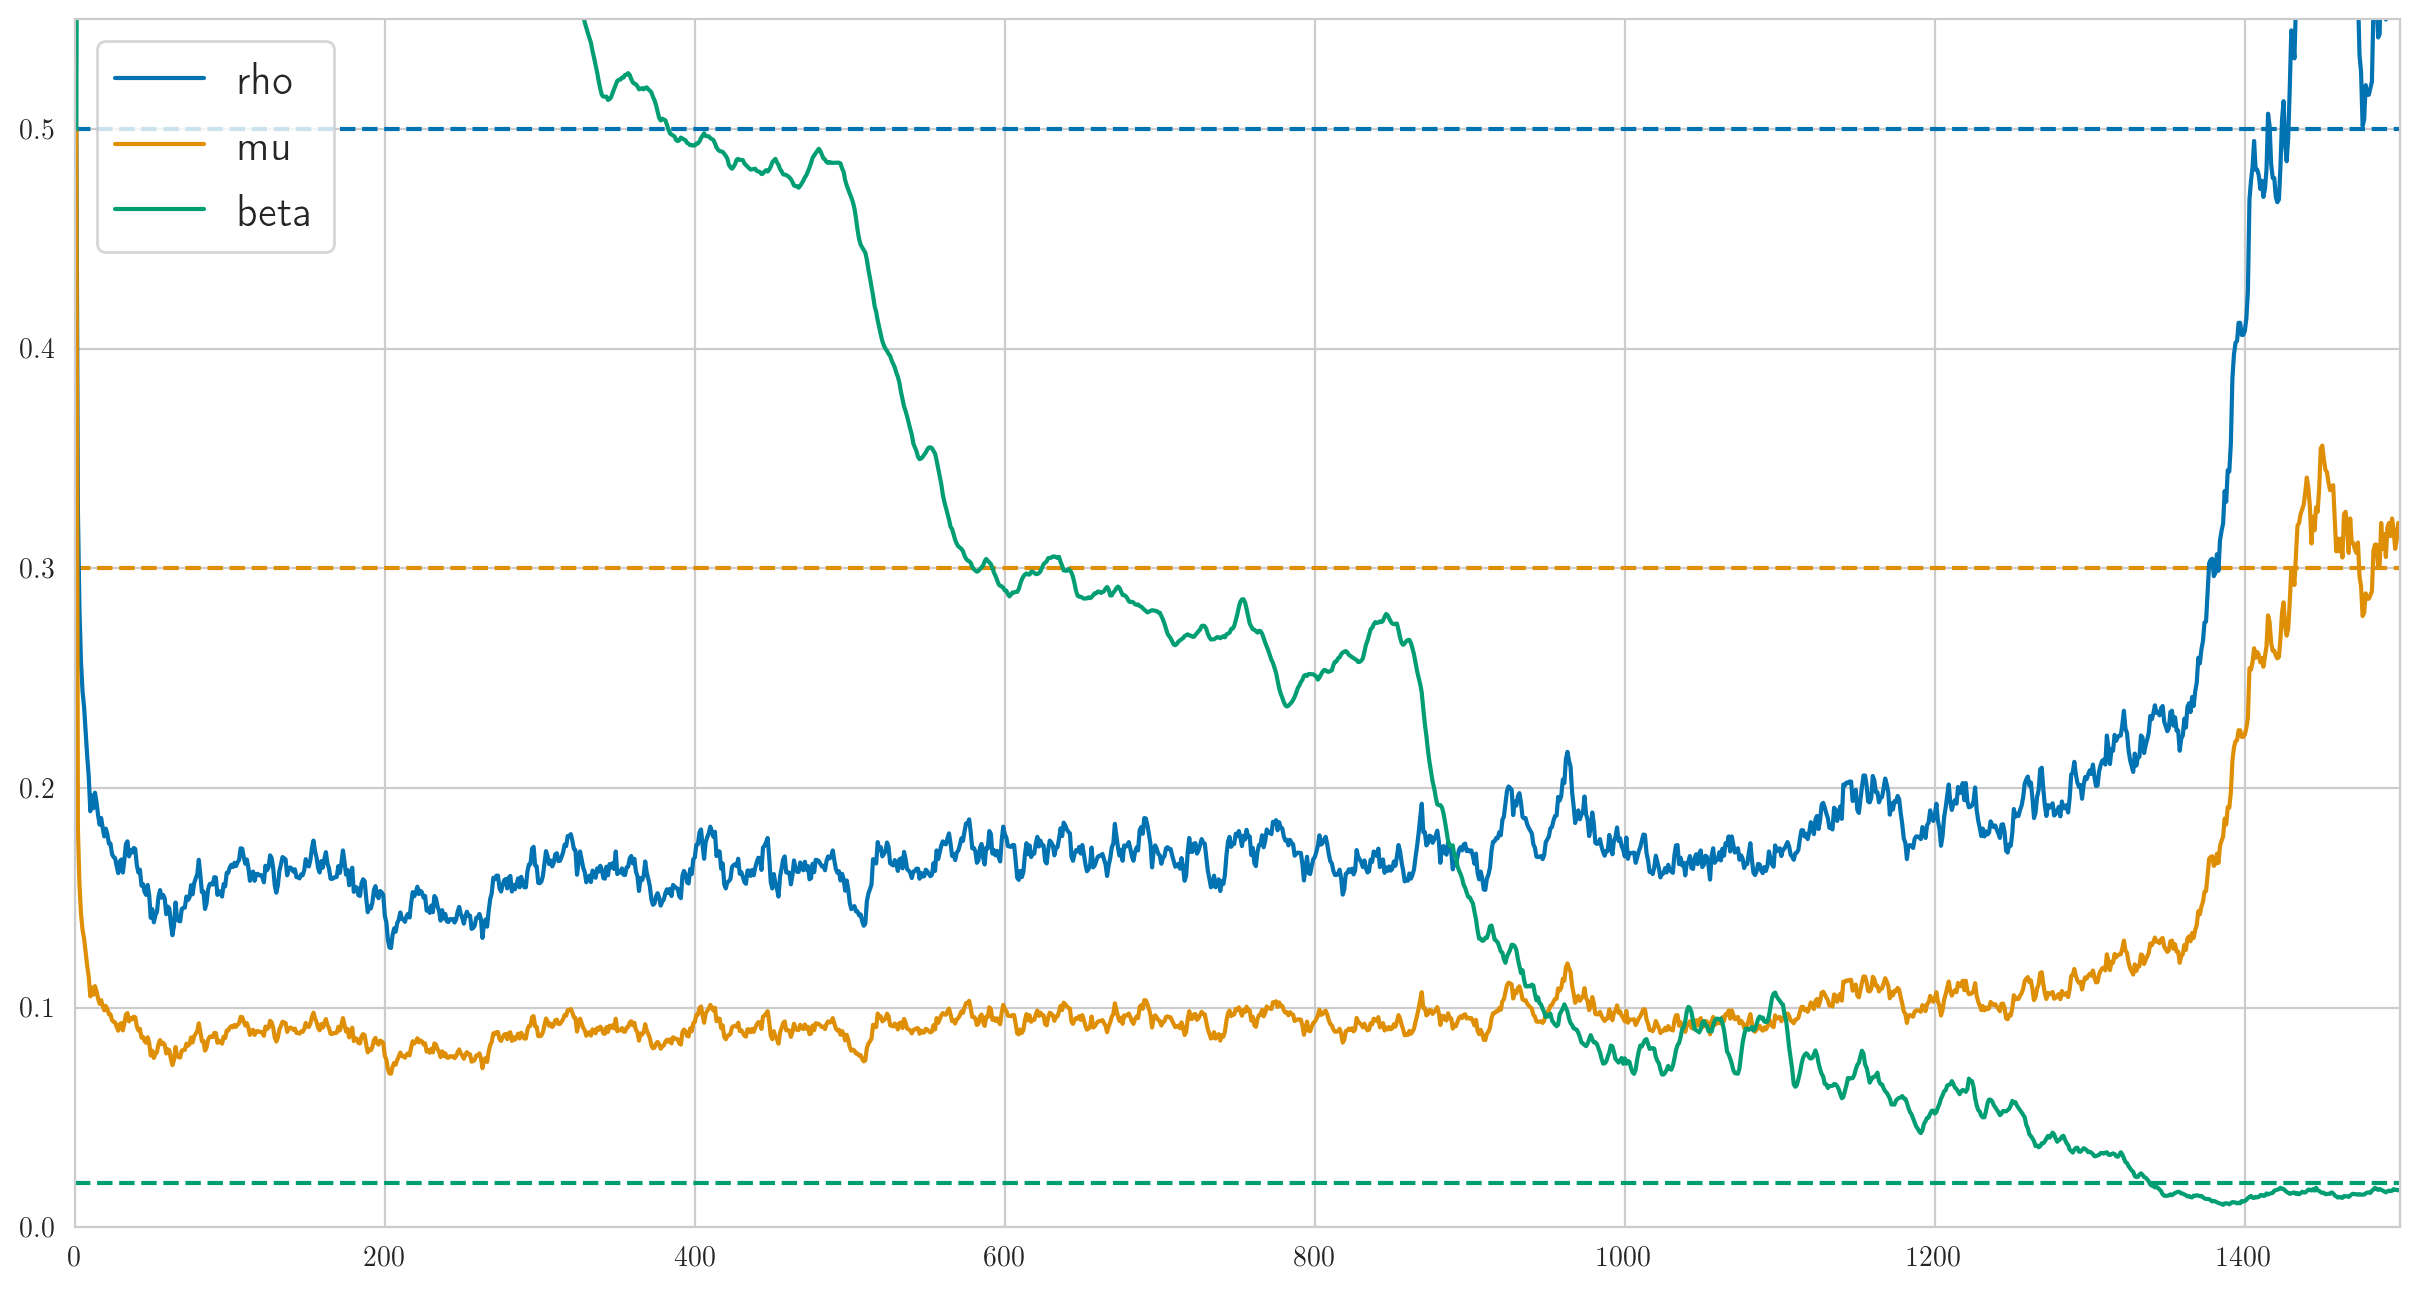

In [26]:
print(true_params)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
plot_model_params_history(ax, model, true_params)
ax.set_ylim((0, 0.55))
ax.set_xlim((0, 1500))
# plt.savefig('covid2.png', bbox_inches='tight')

for i, name in enumerate(model.param_names):
    print("%s: global=%.05f\tlast100=%.05f" % (name, beta_mean( (np.sum([x[0] for x in model.params_history[name]]), np.sum([x[1] for x in model.params_history[name]]) )), beta_mean( (np.sum([x[0] for x in model.params_history[name][-100:]]), np.sum([x[1] for x in model.params_history[name][-100:]]) ))   ))

In [27]:
def plot_model_and_true_arrays(ax, true_stats, model):
    for i,line in enumerate(true_stats):
        ax.plot(line, color=palette[i])
    for i,line in enumerate([model.arr_S, model.arr_I, model.arr_R]):
        ax.plot(line, color=palette[i], linestyle='dashed')
    ax.legend(["S", "I", "R", "S model", "I model", "R model"])

Observed data: [1, 1, 1, 0, 1, 3, 4, 7, 22, 26, 31, 25, 21, 12, 10, 8, 3, 3, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Average sample from true parameters (dev=64.5707):
[ 1.     1.364  3.602  8.828 16.386 23.266 24.512 21.654 16.912 12.142
  8.904  6.294  4.516  3.04   2.24   1.5    1.08   0.724  0.544  0.476
  0.272  0.2    0.152  0.098  0.07   0.044  0.028  0.016  0.014  0.016
  0.006  0.006  0.002  0.004  0.002  0.002  0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.   ]
Average sample from model parameters (dev=55.0167):
[ 1.     1.246  3.004  6.352 12.32  19.274 23.952 23.626 20.442 16.194
 12.024  8.57   6.078  4.29   2.904  2.062  1.416  0.912  0.656  0.418
  0.268  0.176  0.14   0.106  0.07   0.044  0.044  0.024  0.012  0.008
  0.008  0.008  0.004  0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.   ]
Avera

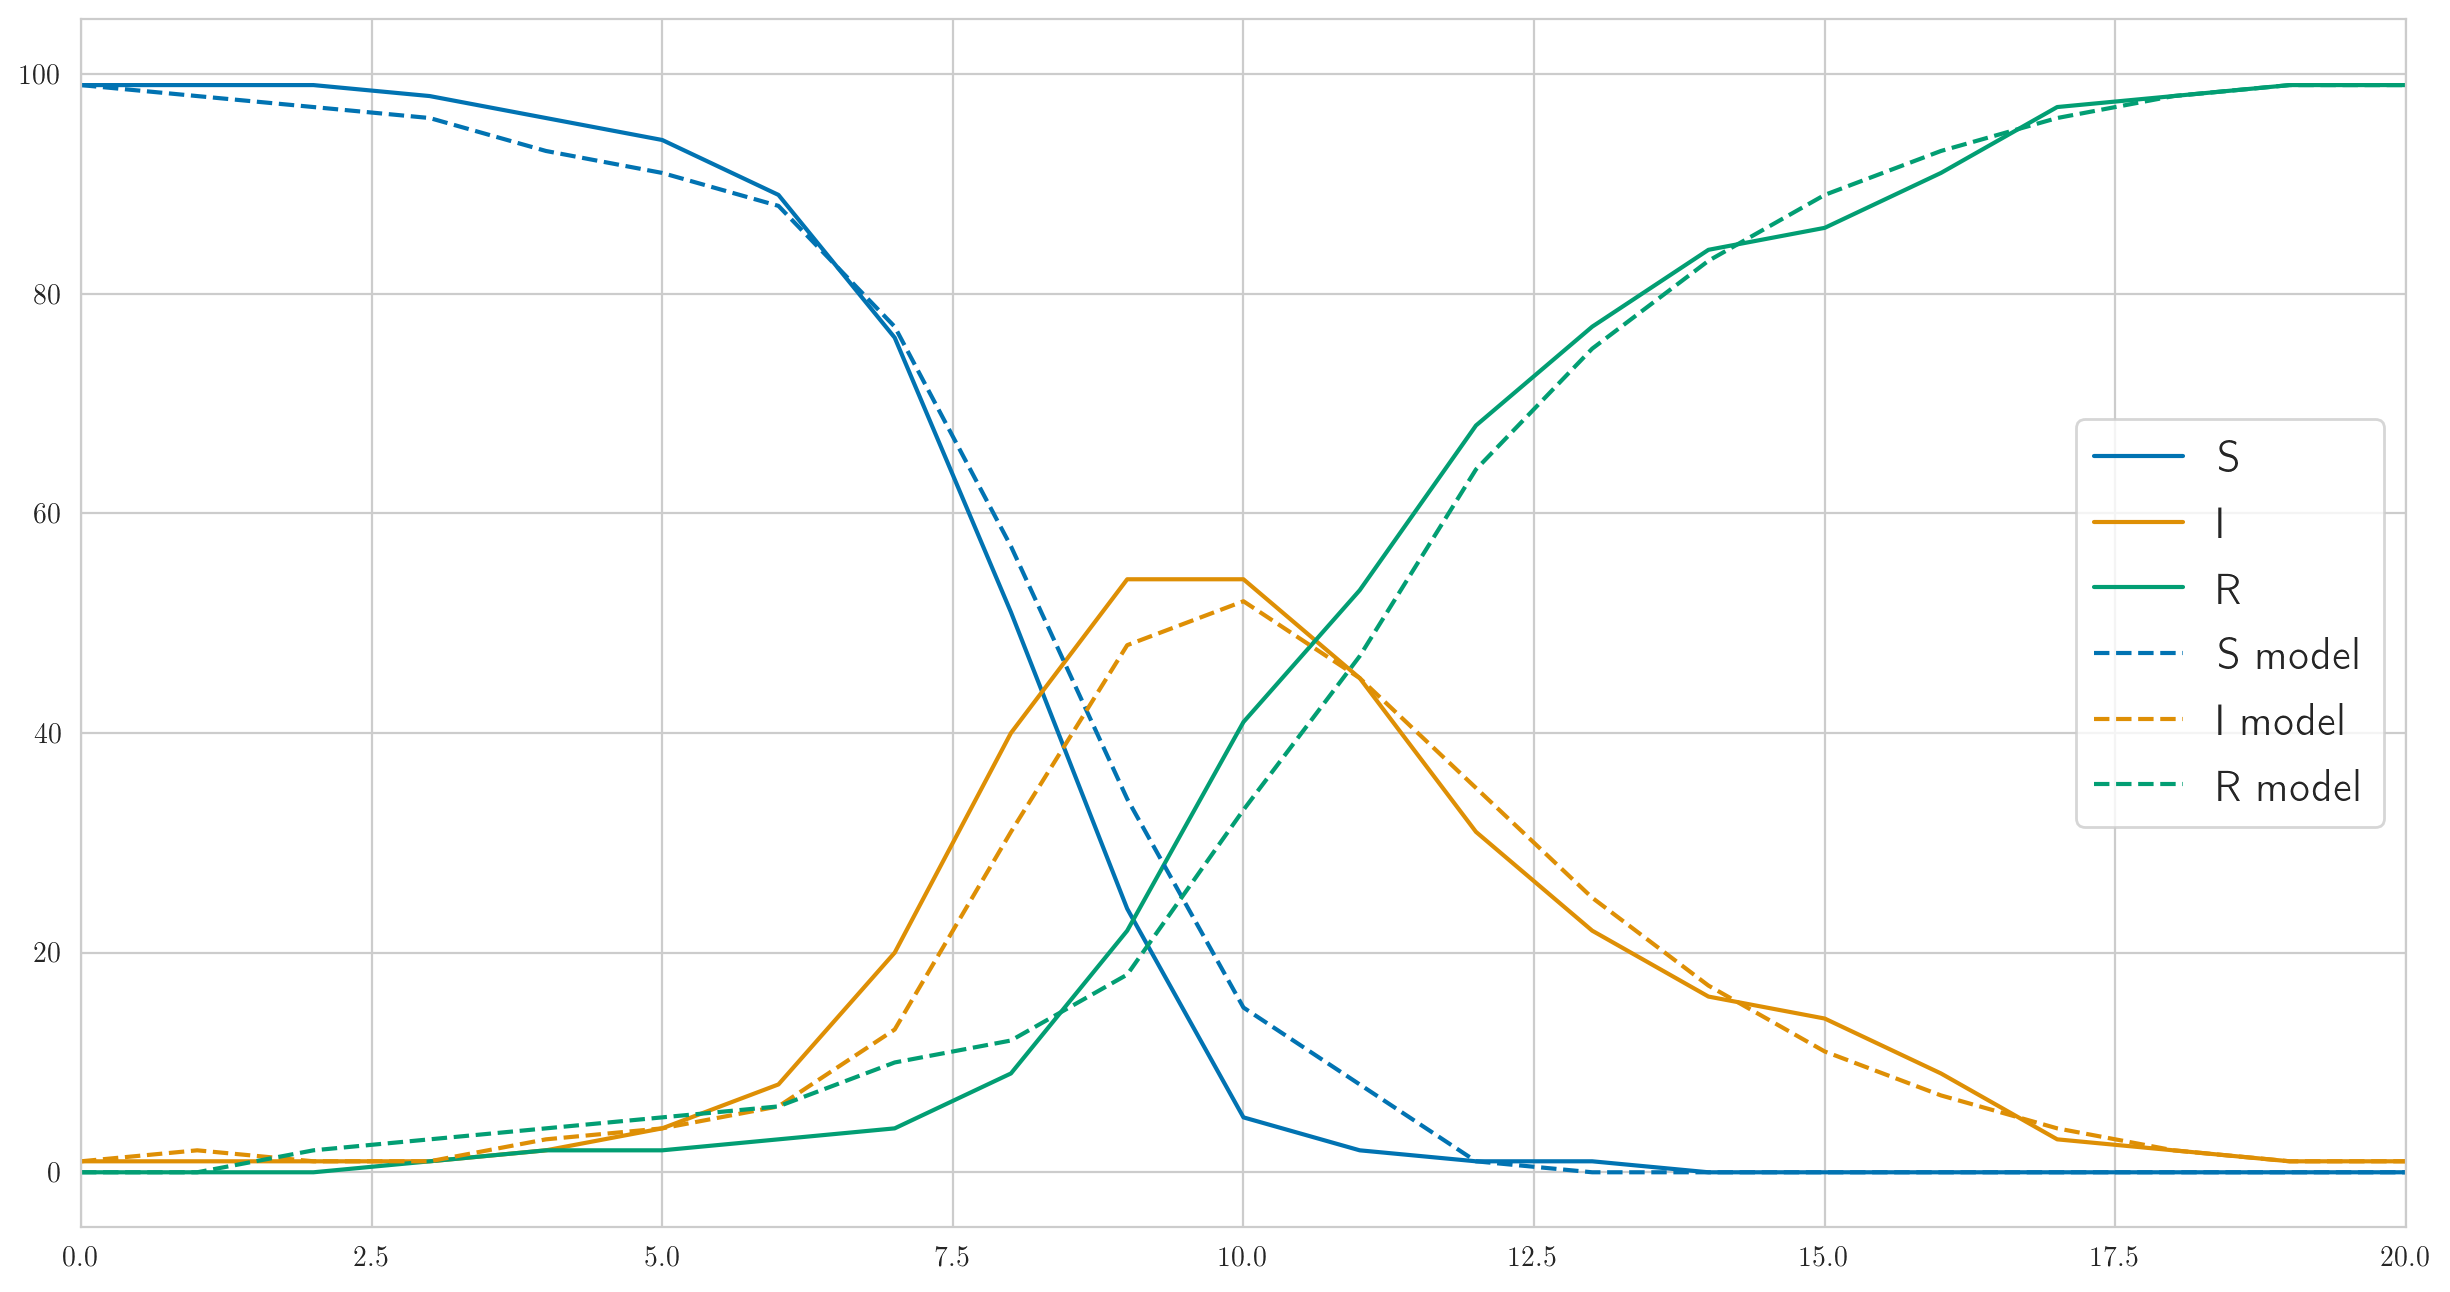

In [28]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
plot_model_and_true_arrays(ax, true_statistics, model)
ax.set_xlim((0, 20))
# fig.savefig('covid3.png', bbox_inches='tight')

mean_params = {
   name : beta_mean( (np.sum([x[0] for x in model.params_history[name][-100:]]), np.sum([x[1] for x in model.params_history[name][-100:]]) ))
    for name in model.param_names }

print("Observed data: %s" % test_y)
true_sample, model_sample, mean_sample = [], [], []
for _ in range(500):
    model_sample.append(sample_population(N, T, model.rho, model.beta, model.mu)[0])
    true_sample.append(sample_population(N, T, true_rho, true_beta, true_mu)[0])
    mean_sample.append(sample_population(N, T, mean_params['rho'], mean_params['beta'], mean_params['mu'])[0])
    
print("Average sample from true parameters (dev=%.4f):\n%s" % (np.mean((np.array(true_sample)-test_y)**2), np.mean(np.array(true_sample), axis=0)))
print("Average sample from model parameters (dev=%.4f):\n%s" % (np.mean((np.array(model_sample)-test_y)**2), np.mean(np.array(model_sample), axis=0)))
print("Average sample from mean parameters (dev=%.4f):\n%s" % (np.mean((np.array(mean_sample)-test_y)**2), np.mean(np.array(mean_sample), axis=0)))